In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator


In [2]:
# Initialisation de Spark
spark = SparkSession.builder.appName("Titanic_Classification_Optimized")  \
    .config("spark.master","spark://spark-master:7077")\
    .getOrCreate()

In [3]:
# Charger les données depuis HDFS 
data_path = "hdfs://namenode:9000/user/data/titanic.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)

In [4]:
# Afficher les colonnes pour comprendre la structure des données
df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



In [5]:
# Filtrer et sélectionner les colonnes utiles
df = df.select(
    col("Survived").alias("label"),  # Étiquette : survie (0 ou 1)
    "Pclass",     # Classe du passager
    "Sex",        # Sexe
    "Age",        # Âge
    "SibSp",      # Nombre de frères et sœurs/époux à bord
    "Parch",      # Nombre de parents/enfants à bord
    "Fare",       # Tarif payé
    "Embarked"    # Port d'embarquement
)

In [6]:
# Supprimer les lignes avec des valeurs nulles
df = df.dropna()

In [7]:
# Encodage des variables catégoriques (ex. Sex, Embarked)
sex_indexer = StringIndexer(inputCol="Sex", outputCol="SexIndex")
embarked_indexer = StringIndexer(inputCol="Embarked", outputCol="EmbarkedIndex")
df = sex_indexer.fit(df).transform(df)
df = embarked_indexer.fit(df).transform(df)

In [8]:
# Assembleur pour créer un vecteur de features
assembler = VectorAssembler(
    inputCols=["Pclass", "SexIndex", "Age", "SibSp", "Parch", "Fare", "EmbarkedIndex"],
    outputCol="features"
)
df = assembler.transform(df)

In [9]:
# Diviser les données en ensembles d'entraînement et de test
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

In [10]:
# Modèle de régression logistique pour la classification binaire
lr = LogisticRegression(featuresCol="features", labelCol="label")
model = lr.fit(train_data)

In [11]:
# Évaluation sur l'ensemble de test
predictions = model.transform(test_data)

In [12]:
# Évaluation des performances du modèle
evaluator = BinaryClassificationEvaluator(
    labelCol="label", 
    rawPredictionCol="rawPrediction", 
    metricName="areaUnderROC"
)
roc_auc = evaluator.evaluate(predictions)
print(f"Area Under ROC Curve (AUC): {roc_auc}")

Area Under ROC Curve (AUC): 0.8609547820380089


In [16]:
# Résultats du modèle
predictions.select("Pclass", "Sex", "Age", "Fare", "label", "prediction").tail(50)

[Row(Pclass=3, Sex='male', Age=46, Fare=151.6337919, label=1, prediction=0.0),
 Row(Pclass=3, Sex='male', Age=46, Fare=34.98288662, label=1, prediction=0.0),
 Row(Pclass=3, Sex='male', Age=46, Fare=43.21365122, label=1, prediction=0.0),
 Row(Pclass=3, Sex='male', Age=46, Fare=60.94641072, label=1, prediction=0.0),
 Row(Pclass=3, Sex='male', Age=47, Fare=0.0, label=1, prediction=0.0),
 Row(Pclass=3, Sex='male', Age=47, Fare=0.0, label=1, prediction=0.0),
 Row(Pclass=3, Sex='male', Age=47, Fare=0.0, label=1, prediction=0.0),
 Row(Pclass=3, Sex='male', Age=47, Fare=6.771375778, label=1, prediction=0.0),
 Row(Pclass=3, Sex='male', Age=47, Fare=9.402783703, label=1, prediction=0.0),
 Row(Pclass=3, Sex='male', Age=47, Fare=12.96514838, label=1, prediction=0.0),
 Row(Pclass=3, Sex='male', Age=47, Fare=25.65088852, label=1, prediction=0.0),
 Row(Pclass=3, Sex='male', Age=47, Fare=30.80806072, label=1, prediction=0.0),
 Row(Pclass=3, Sex='male', Age=47, Fare=0.0, label=1, prediction=0.0),
 Row(

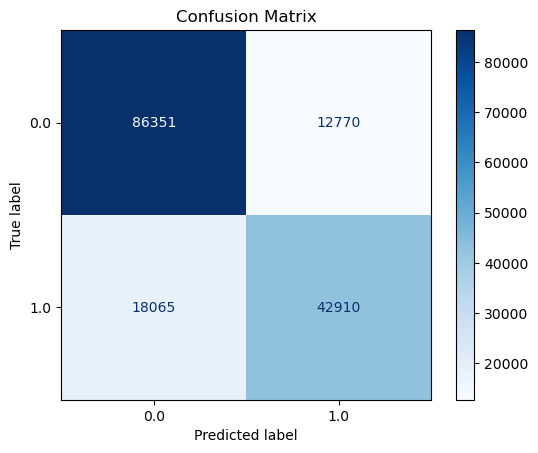

In [24]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Extraction des prévisions et des labels pour la matrice de confusion
predictions_df = predictions.select("label", "prediction").toPandas()

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(predictions_df["label"], predictions_df["prediction"])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.summary.labels)

# Visualisation de la matrice de confusion
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

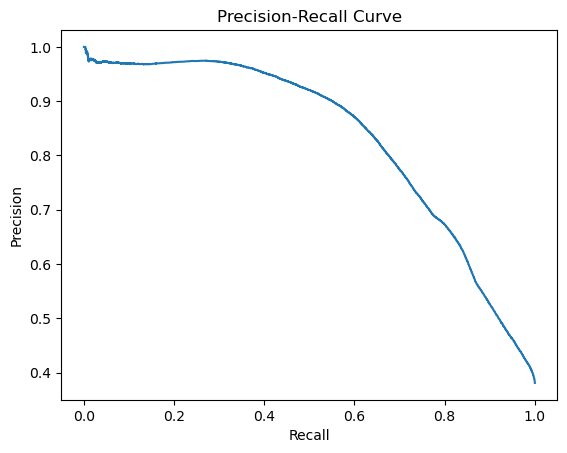

In [25]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
# Extraction des probabilités et des labels
predictions_df = predictions.select("label", "probability").toPandas()

# Calcul de la courbe Precision-Recall
precision, recall, _ = precision_recall_curve(predictions_df["label"], predictions_df["probability"].apply(lambda x: x[1]))

# Affichage de la courbe Precision-Recall
PrecisionRecallDisplay(precision=precision, recall=recall).plot()
plt.title("Precision-Recall Curve")
plt.show()